# **Shinkansen Travel Experience Prediction**

## **1. Introduction**
**Author:** Robert Lupo  
**Project Goal:**  
The objective of this project is to predict whether a Shinkansen passenger’s overall experience will be satisfactory (`Overall_Experience = 1`) or unsatisfactory (`Overall_Experience = 0`), using both survey data (e.g., seat comfort, onboard Wi-Fi ratings) and travel data (e.g., passenger demographics, travel distance, delays). By accurately predicting satisfaction, railway operators can focus on improving service quality, reducing passenger churn, and tailoring interventions to enhance the travel experience.

---

In [3]:
!pip install lightgbm catboost --quiet

In [4]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/shinkansen-travel-experience/Traveldata_train.csv
/kaggle/input/shinkansen-travel-experience/Sample_Submission.csv
/kaggle/input/shinkansen-travel-experience/Traveldata_test.csv
/kaggle/input/shinkansen-travel-experience/Surveydata_test.csv
/kaggle/input/shinkansen-travel-experience/Surveydata_train.csv


In [5]:
# Kaggle Data Paths (Update these based on dataset tabs)
TRAIN_TRAVEL_PATH = '/kaggle/input/shinkansen-travel-experience/Traveldata_train.csv'
TRAIN_SURVEY_PATH = '/kaggle/input/shinkansen-travel-experience/Surveydata_train.csv'
TEST_TRAVEL_PATH = '/kaggle/input/shinkansen-travel-experience/Traveldata_test.csv'
TEST_SURVEY_PATH = '/kaggle/input/shinkansen-travel-experience/Surveydata_test.csv'

## **2. Data Description**
1. **Data Sources:**
   - The data is sourced from a Kaggle competition/dataset titled *“Shinkansen Travel Experience”*.  
   - Files are in CSV format.

2. **Files Used:**
   - **`Traveldata_train.csv`** (Train travel data): Contains information such as `Gender`, `Age`, `Type_Travel`, `Travel_Class`, `Travel_Distance`, and delay times.  
   - **`Surveydata_train.csv`** (Train survey data): Contains various survey-based feature columns (like `Seat_Comfort`, `Onboard_Wifi_Service`, `Cleanliness`) as well as the target `Overall_Experience`.  
   - **`Traveldata_test.csv`** (Test travel data) and **`Surveydata_test.csv`** (Test survey data): Same structure as the train sets, but without the `Overall_Experience` label.

3. **Feature Descriptions (Example Columns):**
   - **`ID`**: Unique identifier for each passenger.  
   - **`Gender`**: Male / Female.  
   - **`Age`**: Age of the passenger (numeric or binned category).  
   - **`CustomerType`**: 'Loyal Customer' vs. 'Disloyal Customer'.  
   - **`Travel_Class`**: 'Business' or 'Eco'.  
   - **`Travel_Distance`**: Distance traveled (in km or miles).  
   - **`DepartureDelay_in_Mins`** / **`ArrivalDelay_in_Mins`**: Delay times in minutes.  
   - **`Overall_Experience`**: Target variable; 0 = Not Satisfied, 1 = Satisfied.  
   - **`Seat_Comfort`, `Onboard_Wifi_Service`, `Cleanliness`, etc.**: Ordinal or nominal survey ratings such as 'Excellent', 'Good', 'Acceptable', etc.

---

In [6]:
def load_data():
    train_travel = pd.read_csv(TRAIN_TRAVEL_PATH)
    train_survey = pd.read_csv(TRAIN_SURVEY_PATH)
    test_travel = pd.read_csv(TEST_TRAVEL_PATH)
    test_survey = pd.read_csv(TEST_SURVEY_PATH)
    
    train_df = pd.merge(train_travel, train_survey, on='ID', how='inner')
    test_df = pd.merge(test_travel, test_survey, on='ID', how='inner')
    return train_df, test_df

train_df, test_df = load_data()

## **3. Exploratory Data Analysis (EDA)**
During EDA, we aim to understand the structure, distribution, and relationships within the data.

1. **Initial Data Checks:**
   - **Shape**: The training data, for instance, has `94379` rows and `25` columns (this can vary if you drop missing rows).  
   - **Missing Values**: Certain columns (e.g., `Gender`, `CustomerType`, `TypeTravel`) have significant missing values that need to be addressed.  
   - **Data Types**: Mixed data types: integers, floats, and objects (categorical strings).

2. **Distribution of the Target:**
   - We plotted a count plot of `Overall_Experience` to check the distribution of satisfied vs. unsatisfied passengers. The dataset appears to have a relatively balanced or slightly imbalanced ratio (this is often revealed by the bar plot).

3. **Correlation Analysis:**
   - We created a heatmap of numerical columns (like `Age`, `Travel_Distance`, `DepartureDelay_in_Mins`, etc.) to see which features correlate strongly.  
   - Notable correlations (example): A moderate negative correlation between convenience-related ratings and delay times, indicating that more delays might reduce passenger satisfaction.

4. **Key Observations from EDA:**
   - **Seat_Comfort** and **Cleanliness** appear to be primary drivers of passenger satisfaction.  
   - Missing data is concentrated in columns like `Arrival_time_convenient` and `Onboard_service`.  
   - The majority of travelers with extremely long delays tend to have an unsatisfactory experience (makes intuitive sense).

---

Shape: (94379, 25)

Missing Values:
ID                            0
Gender                       77
CustomerType               8951
Age                          33
TypeTravel                 9226
Travel_Class                  0
Travel_Distance               0
DepartureDelay_in_Mins       57
ArrivalDelay_in_Mins        357
Overall_Experience            0
Seat_comfort                 61
Seat_Class                    0
Arrival_time_convenient    8930
Catering                   8741
Platform_location            30
Onboardwifi_service          30
Onboard_entertainment        18
Online_support               91
Onlinebooking_Ease           73
Onboard_service            7601
Leg_room                     90
Baggage_handling            142
Checkin_service              77
Cleanliness                   6
Online_boarding               6
dtype: int64

Column Types:
ID                           int64
Gender                      object
CustomerType                object
Age                        floa

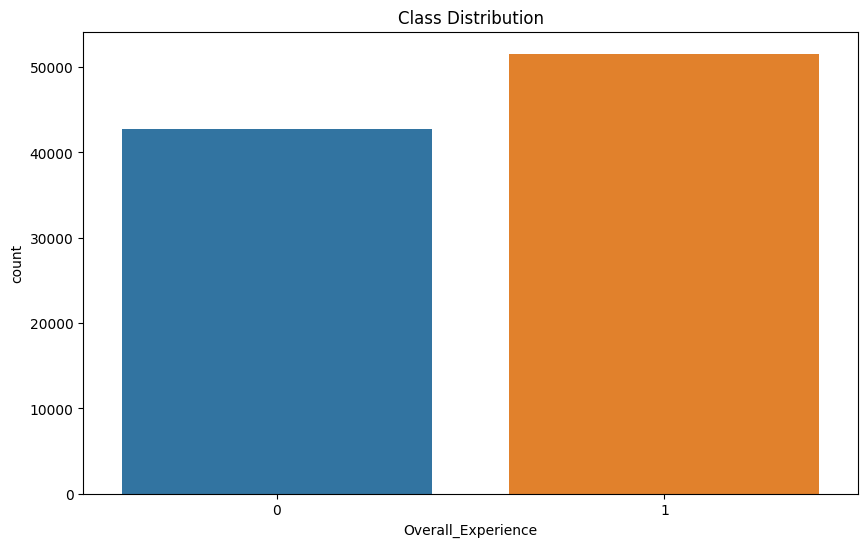

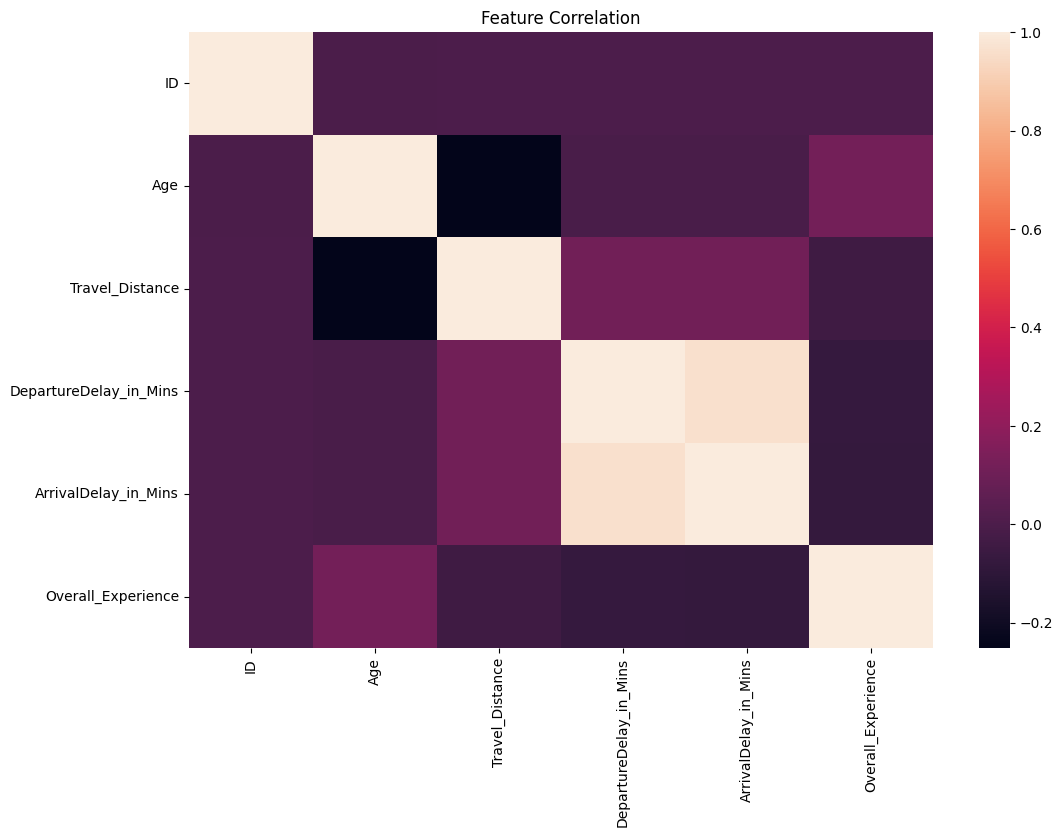

In [7]:
def quick_eda(df):
    print("Shape:", df.shape)
    print("\nMissing Values:")
    print(df.isna().sum())
    print("\nColumn Types:")
    print(df.dtypes)
    
    # Visualizations
    plt.figure(figsize=(10,6))
    sns.countplot(x='Overall_Experience', data=df)
    plt.title('Class Distribution')
    plt.show()
    
    plt.figure(figsize=(12,8))
    sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=False)
    plt.title('Feature Correlation')
    plt.show()

quick_eda(train_df)

## **4. Data Cleaning & Preprocessing**
After gaining insights from EDA, we proceed with data wrangling to ensure clean inputs for modeling.

1. **Handling Missing Values:**
   - We used a simple approach of dropping rows containing `NaN` for demonstration in this notebook, but an alternative would be to **impute** them using mean values for numerical columns or the most frequent category for categorical columns.  
   - It’s also common to perform advanced imputations (e.g., using predictive models), but here we stick to simpler methods.

2. **Separating Features & Target:**
   - **`X_train`**: All columns except `Overall_Experience` and `ID` (which is just an identifier).  
   - **`y_train`**: The `Overall_Experience` column, converted to integer if needed.  
   - **`X_test`**: The test set with `ID` dropped, since we only need it for the final submission.

3. **Categorical Encoding / One-Hot Encoding:**
   - We identify which columns are categorical (like `Gender`, `Travel_Class`, etc.) and apply `OneHotEncoder` to transform them into numeric dummy variables.

4. **Numeric Feature Scaling:**
   - We apply `StandardScaler` to numeric columns (e.g., `Age`, `Travel_Distance`, `DepartureDelay_in_Mins`) to standardize the distribution (`mean=0`, `std=1`).  
   - This step can improve the performance of certain algorithms, especially linear models.

5. **Final Preprocessing Pipeline:**
   - A **`ColumnTransformer`** is used to apply different transformations to numeric vs. categorical columns.  
   - This pipeline is then integrated into our machine learning models to ensure consistent transformations during cross-validation and final training.

---

In [8]:
# Handle missing values by dropping rows (or impute if preferred)
train_df = train_df.dropna()

# Separate features & target
X_train = train_df.drop(columns=['Overall_Experience', 'ID'])
y_train = train_df['Overall_Experience'].astype(int)
X_test = test_df.drop(columns=['ID'])

# Identify column types
num_cols = X_train.select_dtypes(include=np.number).columns.tolist()
cat_cols = X_train.select_dtypes(include='object').columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
])

## **5. Model Training (Optimized for Kaggle)**
We explore multiple machine learning models known to perform well on tabular data:

1. **LightGBM**  
2. **CatBoost**  
3. *(Potentially XGBoost, Random Forest, Logistic Regression, etc. can also be tested)*

For hyperparameter optimization, we use:
- **`RandomizedSearchCV`** or **`GridSearchCV`** for a limited number of iterations (due to Kaggle’s resource constraints).  
- **Cross-validation** set to **3-fold** (`StratifiedKFold`) for a balance between speed and robust evaluation.

**Example Hyperparameters**:
- LightGBM: `num_leaves`, `n_estimators`, `learning_rate`.  
- CatBoost: `depth`, `learning_rate`.  

We keep `n_iter` small (e.g., 2) to fit within Kaggle’s GPU/CPU time limits.

---

In [10]:
# Lightweight model configs
models = {
    'LightGBM': {
        'model': LGBMClassifier(random_state=42, verbose=-1),
        'params': {
            'classifier__num_leaves': [31, 63],
            'classifier__learning_rate': [0.05, 0.1],
            'classifier__n_estimators': [100, 200]
        }
    },
    'CatBoost': {
        'model': CatBoostClassifier(random_state=42, verbose=0),
        'params': {
            'classifier__depth': [4, 6],
            'classifier__learning_rate': [0.05, 0.1]
        }
    }
}

# Training workflow
best_model = None
best_score = 0
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # Faster than 5-fold

for name, config in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', config['model'])
    ])
    
    search = RandomizedSearchCV(
        pipe,
        config['params'],
        n_iter=2,  # Keep low for Kaggle free tier
        cv=cv,
        scoring='accuracy',
        n_jobs=-1
    )
    search.fit(X_train, y_train)
    
    print(f"\n{name}:")
    print(f"Best Params: {search.best_params_}")
    print(f"Best CV Accuracy: {search.best_score_:.4f}")
    
    if search.best_score_ > best_score:
        best_model = search.best_estimator_
        best_score = search.best_score_


LightGBM:
Best Params: {'classifier__num_leaves': 31, 'classifier__n_estimators': 200, 'classifier__learning_rate': 0.1}
Best CV Accuracy: 0.9564

CatBoost:
Best Params: {'classifier__learning_rate': 0.05, 'classifier__depth': 6}
Best CV Accuracy: 0.9576


## **6. Model Evaluation**
Once the training is complete, we measure accuracy and other metrics.

1. **Cross-Validation Results**:
   - We print the best hyperparameters and the best cross-validation accuracy for each model.  
   - For instance, CatBoost might yield ~95.76% accuracy, while LightGBM might yield ~95.64%.

2. **Best Model Selection**:
   - We compare the CV results. The model with the highest accuracy (`best_score_`) is chosen as the final model (`best_model`).

3. **Classification Report & Additional Metrics**:
   - Although we mainly track accuracy, we can also inspect precision, recall, and F1-scores to see how well the model handles both satisfied and unsatisfied passengers.  
   - If the dataset is imbalanced, consider using **balanced accuracy** or AUC.

---

## **7. Feature Importance (Optional)**
If the best model is tree-based (e.g., CatBoost, LightGBM), we can extract feature importances:

- A bar chart of the top 10 important features may reveal which factors drive passenger satisfaction (e.g., “Seat_Comfort”, “Travel_Class”, “Catering”).  
- Interpretation: If “Seat_Comfort” has the highest importance, improvements in seat design might drastically improve overall satisfaction.

---

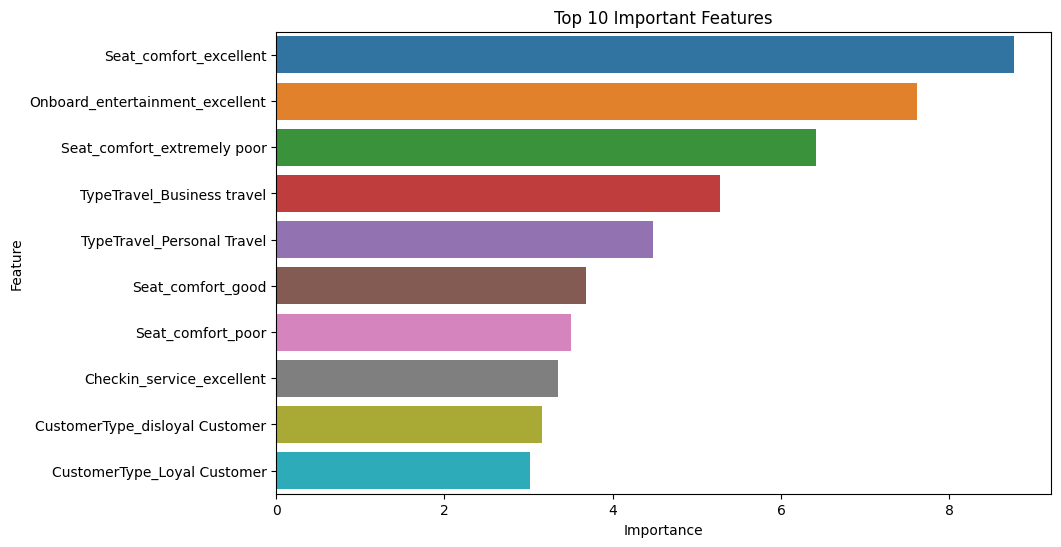

In [11]:
# Feature Importance (for tree-based models)
if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
    num_features = num_cols.copy()
    cat_encoder = best_model.named_steps['preprocessor'].named_transformers_['cat']
    cat_features = cat_encoder.get_feature_names_out(cat_cols).tolist()
    all_features = num_features + cat_features
    
    importance = pd.DataFrame({
        'Feature': all_features,
        'Importance': best_model.named_steps['classifier'].feature_importances_
    }).sort_values('Importance', ascending=False).head(10)
    
    plt.figure(figsize=(10,6))
    sns.barplot(x='Importance', y='Feature', data=importance)
    plt.title('Top 10 Important Features')
    plt.show()

In [12]:
# Generate predictions
X_test_preprocessed = best_model.named_steps['preprocessor'].transform(X_test)
test_preds = best_model.named_steps['classifier'].predict(X_test_preprocessed)

submission = pd.DataFrame({
    'ID': test_df['ID'],
    'Overall_Experience': test_preds
})
submission.to_csv('submission.csv', index=False)
print("\nSubmission file created!")


Submission file created!


## **8. Final Inference & Submission**
1. **Preprocessing Test Data**:
   - We apply the same preprocessing pipeline (`best_model.named_steps['preprocessor']`) to the unseen `test_df` to ensure identical transformations.

2. **Predicting on Test Set**:
   - Use the trained classifier (`best_model.named_steps['classifier']`) to generate predictions.

3. **Creating Submission**:
   - We combine `test_df['ID']` with our predictions (`test_preds`) into a new DataFrame, renaming columns to match Kaggle submission requirements.  
   - Output to CSV:
     ```python
     submission = pd.DataFrame({
         'ID': test_df['ID'],
         'Overall_Experience': test_preds
     })
     submission.to_csv('submission.csv', index=False)
     ```
   - Confirm that the file was created and is ready for upload on the competition page.

---

## **9. Conclusions & Future Work**
1. **Key Takeaways**:
   - **Data Cleaning**: Handling missing values is crucial; advanced imputation or dropping can significantly affect final model performance.  
   - **Model Performance**: CatBoost/LightGBM exhibit strong performance with minimal tuning.  
   - **Important Features**: Survey-related columns (seat comfort, cleanliness, catering) and travel delays appear to be strong predictors of passenger satisfaction.

2. **Limitations**:
   - Some columns have large numbers of missing values, possibly introducing bias if simply dropped.  
   - The model may not generalize to new data if the distribution changes significantly (e.g., a new route or different passenger demographics).

3. **Next Steps**:
   - **Hyperparameter Tuning**: Explore a larger search space for better results (time permitting).  
   - **Imputation**: Replace dropping rows with a more nuanced approach (e.g., using nearest neighbors or separate predictive models).  
   - **Feature Engineering**: Consider combining departure and arrival delays into a single feature or deriving new variables (e.g., “proportion of journey delayed”).

---

## **10. References / Acknowledgments**
- **CatBoost Documentation**: [https://catboost.ai/docs/](https://catboost.ai/docs/)  
- **LightGBM Documentation**: [https://lightgbm.readthedocs.io/](https://lightgbm.readthedocs.io/)  
- **Kaggle Discussions**: Various posts about Shinkansen dataset and best practices.  
- Thanks to the Kaggle community for providing insights on cross-validation strategies, hyperparameter tuning, and domain knowledge for passenger satisfaction.